In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 定义导入,导出路径
# 数据导入

folder_path = r"E:\Test\Inputs"
folder_path_output = r"E:\Test\Outputs"

file_WWTP = os.path.join(folder_path, "WWTP_corrected.xlsx")
df_WWTP = pd.read_excel(file_WWTP)

file_CFPP =  os.path.join(folder_path, "CFPP.xlsx")
df_CFPP = pd.read_excel(file_CFPP)

file_WIPP =  os.path.join(folder_path, "WIPP.xlsx")
df_WIPP = pd.read_excel(file_WIPP)

file_intesity =  os.path.join(folder_path, "province_intensity.xlsx")
df_intesity = pd.read_excel(file_intesity)

## 情景参数

In [3]:
# Scenario Parameters
MixRate_Max_low = 0.05
MixRate_Max_high = 0.10

## 比较月污泥量,可掺烧污泥量上限 (分省比较,总量比较)

In [4]:
# 分省

# 计算月污泥量总量
df_Sludge_Mon = df_WWTP.groupby(['Province', 'Statistical month'])['含水率45%时的总污泥处理量（吨/月）'].sum().div(1000).reset_index()
df_Sludge_Mon.rename(columns={ '含水率45%时的总污泥处理量（吨/月）': 'Monthly_Sludge_supply_103t'}, inplace=True)

# 计算月煤电厂可掺烧污泥量上限
df_Coal_Ele = df_CFPP.groupby(['Province', 'Statistical month'])['Monthly_Coal_Ele_tce'].sum().div(1000).reset_index()
df_Coal_Heat = df_CFPP.groupby(['Province', 'Statistical month'])['Monthly_Coal_Heat_tce'].sum().div(1000).reset_index()
df_Coal_Mon = df_Coal_Ele.merge(df_Coal_Heat, on=['Province', 'Statistical month'], how='left')
df_Coal_Mon.rename(columns={ 
    'Monthly_Coal_Ele_tce': 'Monthly_Coal_Ele_103tce',
    'Monthly_Coal_Heat_tce':'Monthly_Coal_Heat_103tce'
}, inplace=True)

df_Coal_Mon['Altern_Coal_Ele_103t'] = df_Coal_Mon['Monthly_Coal_Ele_103tce'] * MixRate_Max_low/0.7143
df_Coal_Mon['Altern_Coal_Heat_103t'] = df_Coal_Mon['Monthly_Coal_Heat_103tce'] * MixRate_Max_low/0.7143


# 计算月垃圾焚烧厂可掺烧污泥量上限
df_WIPP_Ele = df_WIPP.groupby(['Province', 'Statistical month'])['Monthly_Waste_Ele_t'].sum().div(1000).reset_index()
df_WIPP_Heat = df_WIPP.groupby(['Province', 'Statistical month'])['Monthly_Waste_Heat_t'].sum().div(1000).reset_index()
df_WIPP_Mon = df_WIPP_Ele.merge(df_WIPP_Heat, on=['Province', 'Statistical month'], how='left')
df_WIPP_Mon.rename(columns={ 
    'Monthly_Waste_Ele_t': 'Monthly_Waste_Ele_103t',
    'Monthly_Waste_Heat_t':'Monthly_Waste_Heat_103t'
}, inplace=True)

df_WIPP_Mon['Altern_Waste_Ele_103t'] = df_WIPP_Mon['Monthly_Waste_Ele_103t'] * MixRate_Max_low
df_WIPP_Mon['Altern_Waste_Heat_103t'] = df_WIPP_Mon['Monthly_Waste_Heat_103t']* MixRate_Max_low

# 合并成一张表
df_Sludge_Mon = pd.merge(df_Sludge_Mon[['Province', 'Statistical month', 'Monthly_Sludge_supply_103t']],
                     df_Coal_Mon[['Province', 'Statistical month', 'Altern_Coal_Ele_103t', 'Altern_Coal_Heat_103t']],
                     on=['Province', 'Statistical month'],
                     how='outer')

df_Sludge_Mon = pd.merge(df_Sludge_Mon,
                     df_WIPP_Mon[['Province', 'Statistical month', 'Altern_Waste_Ele_103t', 'Altern_Waste_Heat_103t']],
                     on=['Province', 'Statistical month'],
                     how='outer')

df_Sludge_Mon.fillna(0, inplace=True)

month_map = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}


df_Sludge_Mon['Month'] = df_Sludge_Mon['Statistical month'].apply(lambda x: month_map[int(str(x)[4:])])
df_Sludge_Mon

,Province,Statistical month,Monthly_Sludge_supply_103t,Altern_Coal_Ele_103t,Altern_Coal_Heat_103t,Altern_Waste_Ele_103t,Altern_Waste_Heat_103t,Month
0,Anhui,202001,43.942004,413.353179,1.371266,23.794691,0.119498,Jan
1,Anhui,202002,34.489970,333.033367,1.371266,19.171078,0.119498,Feb
2,Anhui,202003,50.115463,348.705528,1.371266,20.073247,0.119498,Mar
3,Anhui,202004,50.623959,327.156307,1.371266,18.832765,0.119498,Apr
4,Anhui,202005,59.392059,340.869447,1.371266,19.622163,0.119498,May
...,...,...,...,...,...,...,...,...
367,Zhejiang,202008,147.326677,390.780356,84.153815,57.439329,24.769171,Aug
368,Zhejiang,202009,135.957734,334.838771,84.153815,49.216686,24.769171,Sep
369,Zhejiang,202010,137.003204,311.327089,84.153815,45.760793,24.769171,Oct
370,Zhejiang,202011,146.786648,312.137838,84.153815,45.879962,24.769171,Nov


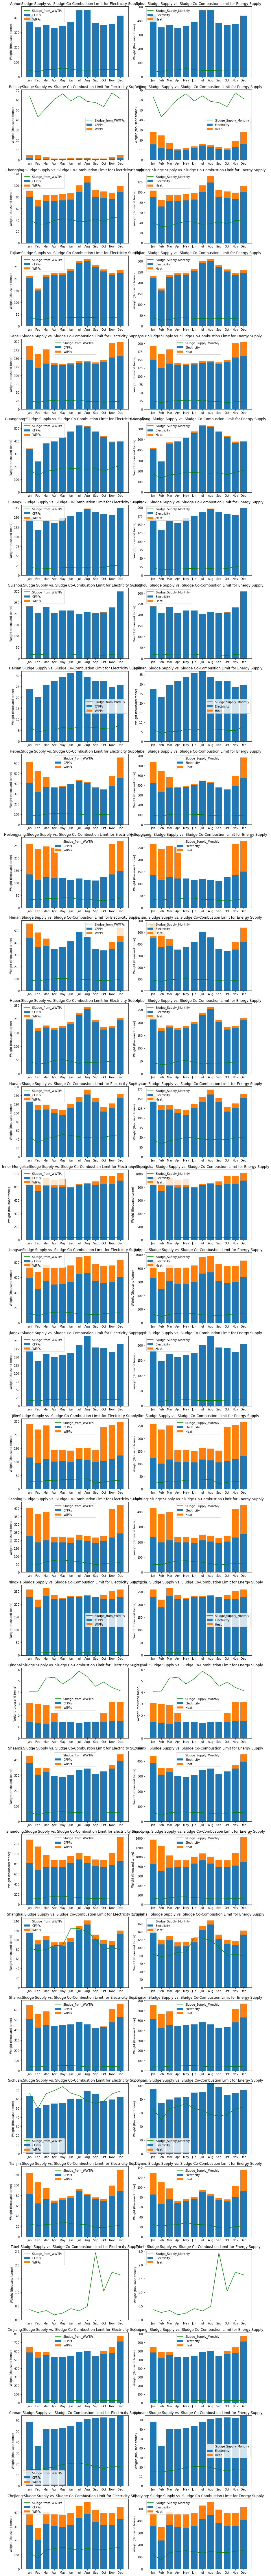

In [6]:
# 绘制图形
# 第1列：表示在仅考虑电力供应燃料需求时，不同发电技术可掺烧燃料上限VS污泥可供应量
# 第2列：考虑电力、热力供应燃料需求时，可掺烧燃料上限VS污泥可供应量


# 计算月可掺烧污泥总量
df_Sludge_Mon['Altern_All_Ele_103t'] = df_Sludge_Mon['Altern_Coal_Ele_103t'] + df_Sludge_Mon['Altern_Waste_Ele_103t']
df_Sludge_Mon['Altern_All_Heat_103t'] = df_Sludge_Mon['Altern_Coal_Heat_103t'] + df_Sludge_Mon['Altern_Waste_Heat_103t']

# df_Sludge_Mon.to_excel(os.path.join(folder_path_output, "SludgeAllMon.xlsx"), index=False)

# 获取省份列表
province_list = df_Sludge_Mon['Province'].unique()

# 创建子图布局
num_rows = len(province_list)
num_cols = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 4*num_rows), squeeze=False)

# 遍历省份列表
for i, province in enumerate(province_list):
    # 获取当前省份数据
    province_data = df_Sludge_Mon[df_Sludge_Mon['Province'] == province]
    
    # 在第1列绘制低掺烧比例的比较情况
    ax1 = axs[i, 0]
    ax1.bar(province_data['Month'], province_data['Altern_Coal_Ele_103t'], label='CFPPs')
    ax1.bar(province_data['Month'], province_data['Altern_Coal_Heat_103t'], bottom=province_data['Altern_Coal_Ele_103t'], label='WIPPs')
    ax1.plot(province_data['Month'], province_data['Monthly_Sludge_supply_103t'], label='Sludge_from_WWTPs ', color = 'green')
    ax1.set_title(f"{province}:Sludge Supply vs. Sludge Co-Combustion Limit for Electricity Supply")
    ax1.set_xticks(province_data['Month'].values)
#     ax1.set_xticklabels(['{:.0f}'.format(label) for label in province_data['Statistical month'].values], rotation = 45)
    ax1.set_ylabel('Weight (thousand tonne)')
    ax1.legend()
    
    # 在第2列绘制高掺烧比例的比较情况
    ax2 = axs[i, 1]
    ax2.bar(province_data['Month'], province_data['Altern_All_Ele_103t'], label='Electricity')
    ax2.bar(province_data['Month'], province_data['Altern_All_Heat_103t'], bottom=province_data['Altern_All_Ele_103t'], label='Heat')
    ax2.plot(province_data['Month'], province_data['Monthly_Sludge_supply_103t'], label='Sludge_Supply_Monthly', color = 'green')
    ax2.set_title(f"{province}: Sludge Supply vs. Sludge Co-Combustion Limit for Energy Supply")
    ax2.set_xticks(province_data['Month'].values)
#     ax2.set_xticklabels(['{:.0f}'.format(label) for label in province_data['Statistical month'].values], rotation = 45)
    ax2.set_ylabel('Weight (thousand tonne)')
    ax2.legend()

# 调整子图布局和间距
fig.tight_layout()

# 显示图表
plt.show()

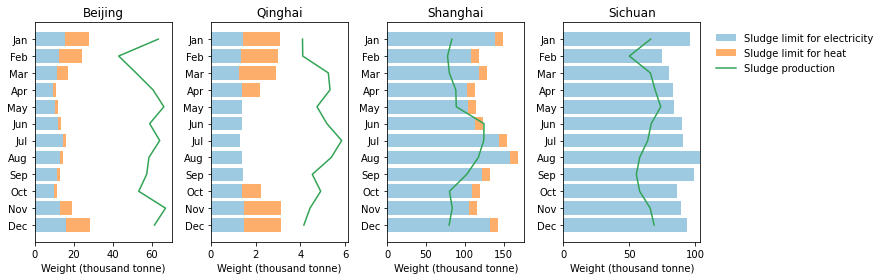

In [6]:
# 计算月可掺烧污泥总量
df_Sludge_Mon['Altern_All_Ele_103t'] = df_Sludge_Mon['Altern_Coal_Ele_103t'] + df_Sludge_Mon['Altern_Waste_Ele_103t']
df_Sludge_Mon['Altern_All_Heat_103t'] = df_Sludge_Mon['Altern_Coal_Heat_103t'] + df_Sludge_Mon['Altern_Waste_Heat_103t']

province_list = ['Beijing', 'Qinghai', 'Shanghai', 'Sichuan']

# 创建子图布局
num_rows = 1
num_cols = len(province_list)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 4*num_rows), squeeze=False)

handles, labels = [], []

# 遍历省份列表
for i, province in enumerate(province_list):
    # 获取当前省份数据
    province_data = df_Sludge_Mon[df_Sludge_Mon['Province'] == province]
    
    ax = axs[0, i]
    # 绘制水平堆积条形图
    bar1 = ax.barh(province_data['Month'], province_data['Altern_All_Ele_103t'], label='Sludge limit for electricity',color = '#9ecae1')
    bar2 = ax.barh(province_data['Month'], province_data['Altern_All_Heat_103t'], left=province_data['Altern_All_Ele_103t'], label='Sludge limit for heat',color = '#fdae6b')
    line, = ax.plot(province_data['Monthly_Sludge_supply_103t'], province_data['Month'], label='Sludge production', color='#31a354')
    
    ax.invert_yaxis()
    ax.set_title(f"{province}")
    ax.set_yticks(province_data['Month'].values)
    ax.set_xlabel('Weight (thousand tonne)')
    
    # 仅在第一次迭代时收集图例句柄和标签
    if i == 0:
        handles.extend([bar1, bar2, line])
        labels = [h.get_label() for h in handles]

# 在整个图形右侧显示一个总体图例
legend = fig.legend(handles=handles, labels=labels, loc='upper right', bbox_to_anchor=(1.23, 0.9), frameon=False)

plt.tight_layout()
plt.savefig(r"C:\Users\Lenovo\Pictures\symbiosis\sludge_2.png",dpi=500, bbox_extra_artists=[legend], bbox_inches='tight')
plt.show()


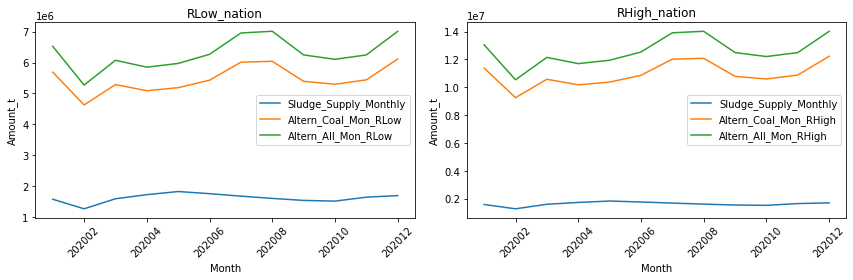

In [7]:
# 总量
# 月污泥量vs仅煤电厂-污水厂协同 以及 月污泥量vs 煤电厂和垃圾焚烧发电厂-污水厂协同 


# 计算所有省份的求和值
sum_sludge = df_Sludge_Mon.groupby('Statistical month')['含水率45%时的总污泥处理量（吨/月）'].sum()
sum_alter_coal_rlow = df_Sludge_Mon.groupby('Statistical month')['Altern_Coal_Mon_RLow'].sum()
sum_alter_coal_rhigh = df_Sludge_Mon.groupby('Statistical month')['Altern_Coal_Mon_RHigh'].sum()
sum_alter_all_rlow = df_Sludge_Mon.groupby('Statistical month')['Altern_All_Mon_RLow'].sum()
sum_alter_all_rhigh = df_Sludge_Mon.groupby('Statistical month')['Altern_All_Mon_RHigh'].sum()

# 设置图形大小
fig = plt.figure(figsize=(12, 4))

# 绘制第一张图
plt.subplot(1, 2, 1)
plt.plot(sum_sludge.index, sum_sludge.values, label='Sludge_Supply_Monthly')
plt.plot(sum_alter_coal_rlow.index, sum_alter_coal_rlow.values, label='Altern_Coal_Mon_RLow')
plt.plot(sum_alter_all_rlow.index, sum_alter_all_rlow.values, label='Altern_All_Mon_RLow')
plt.xticks(rotation=45)  
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}"))
plt.xlabel('Month')
plt.ylabel('Amount_t')
plt.title('RLow_nation')
plt.legend()

# 绘制第二张图
plt.subplot(1, 2, 2)
plt.plot(sum_sludge.index, sum_sludge.values, label='Sludge_Supply_Monthly')
plt.plot(sum_alter_coal_rhigh.index, sum_alter_coal_rhigh.values, label='Altern_Coal_Mon_RHigh')
plt.plot(sum_alter_all_rhigh.index, sum_alter_all_rhigh.values, label='Altern_All_Mon_RHigh')
plt.xticks(rotation=45)  
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}"))
plt.xlabel('Month')
plt.ylabel('Amount_t')
plt.title('RHigh_nation')
plt.legend()


plt.tight_layout()  # 调整子图间距
plt.show()